# Exercise 2.8

Compute the area of Italian subdivisions using GeoPandas and plot their area as a bar chart
* Download a shapefile that describe Italian regions (e.g., [here](https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ITA_shp.zip))
* Make a bar chart, put the regions in increasing order of area (put the region’s name on the x axis)
* Repeat for provinces and municipalities (plot only the 100 municipalities with the highest area)
* Plot the shape of each region (in blue), with the shape of its capital municipality (in red)</br>
* Submit a (well-documented) notebook

## Installing the packages

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 4.1 MB/s 
     |███████████████

## Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#for the Voronoi Tessellation
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Polygon, Point

#to download and extract the shape files
import urllib.request
import zipfile
import os

In [ ]:
file_name = 'gadm41_ITA_shp.zip'

#downloading a shp with the italian regions
urllib.request.urlretrieve('https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ITA_shp.zip', file_name)

#extracting the zipped files
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
#removing the zip
os.remove(file_name)

#getting the shp files from the directory
shape_files = [x for x in os.listdir() if x[-3:] == 'shp']
print(shape_files)

['gadm41_ITA_1.shp', 'gadm41_ITA_2.shp', 'gadm41_ITA_0.shp', 'gadm41_ITA_3.shp']


In [ ]:
#after a rapid check I divided the shape files for each administrative subdivision
regions = gpd.read_file(shape_files[0])
provinces = gpd.read_file(shape_files[1])
municipalities = gpd.read_file(shape_files[3])
italy = gpd.read_file(shape_files[2])

## Regions

In [ ]:
#getting the baricenter of italy to balance the crs
italy_center = italy['geometry'][0].centroid.coords[0]
itc_lat = italy_center[0]
itc_lng = italy_center[1]

#to get proper areas it's necessary to adapt the crs (I use)
gdf_reg = regions.copy(deep = True)
gdf_reg = gdf_reg.to_crs(f"+proj=cea +lat_0={itc_lat} +lon_0={itc_lng} +units=m")

#adding the area in squared km to the gdf next to the name so I can confirm correctness
gdf_reg.insert(4, 'AREA', gdf_reg.area / 10**6)

In [ ]:
#max area error from google search isn't higher than 250 m2 from what I checked
gdf_reg

,GID_1,GID_0,COUNTRY,NAME_1,AREA,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,ITA.1_1,ITA,Italy,Abruzzo,10783.543541,Abruzos|Abruzzen|Abruzzes|Abruzz,NA,Regione,Region,13,NA,IT-65,"POLYGON ((-3197154.192 4225763.888, -3197177.7..."
1,ITA.2_1,ITA,Italy,Apulia,19323.418157,Apulien|Pouilles|Pouille|Puglia|,NA,Regione,Region,16,NA,NA,"MULTIPOLYGON (((-2715775.869 4067945.130, -271..."
2,ITA.3_1,ITA,Italy,Basilicata,9988.665767,Basilicate|Lucania,NA,Regione,Region,17,NA,IT-77,"MULTIPOLYGON (((-2970436.445 4071986.711, -297..."
3,ITA.4_1,ITA,Italy,Calabria,15075.720081,Calabre|Calabrie|Kalabrien,NA,Regione,Region,18,NA,IT-78,"MULTIPOLYGON (((-3004618.978 3899979.685, -300..."
4,ITA.5_1,ITA,Italy,Campania,13634.134002,Campanha|Campanie|Kampanien,NA,Regione,Region,15,NA,IT-72,"MULTIPOLYGON (((-3043859.095 4081514.106, -304..."
5,ITA.6_1,ITA,Italy,Emilia-Romagna,22099.302725,Emilia Romagna|Emilia|Emilia-Rom,NA,Regione,Region,8,NA,IT-45,"MULTIPOLYGON (((-3378126.818 4423917.676, -337..."
6,ITA.7_1,ITA,Italy,Friuli-Venezia Giulia,7794.428629,Friuli Venezia Giulia|Friuli-Ven,NA,Regione,Autonomous Region,6,NA,IT-36,"MULTIPOLYGON (((-3216049.425 4538553.503, -321..."
7,ITA.8_1,ITA,Italy,Lazio,17233.602963,Lacio|Latium,NA,Regione,Region,12,NA,IT-62,"MULTIPOLYGON (((-3265199.472 4146878.241, -326..."
8,ITA.9_1,ITA,Italy,Liguria,5455.249784,Ligurie|Ligurien,NA,Regione,Region,7,NA,IT-42,"MULTIPOLYGON (((-3906183.111 4394266.132, -390..."
9,ITA.10_1,ITA,Italy,Lombardia,23899.340573,Lombardy|Lombardei|Lombardie,NA,Regione,Region,3,NA,IT-25,"MULTIPOLYGON (((-3727985.254 4470338.056, -372..."


Text(0.5, 1.0, 'Areas of the Italian regions')

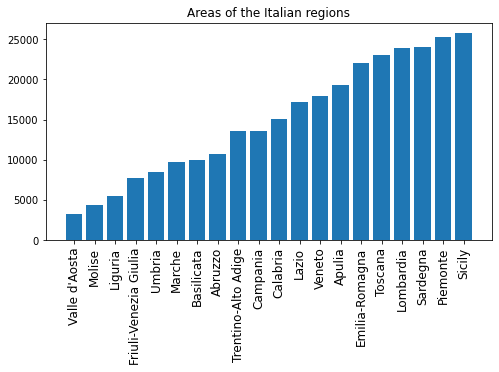

In [ ]:
#sorting regions by area
regions_by_area = np.array(sorted(gdf_reg[['NAME_1', 'AREA', 'geometry']].values, key=lambda x: x[1]))

#plotting the result
plt.figure(figsize=(8,4))
plt.bar(regions_by_area[:,0], regions_by_area[:,1])
plt.xticks(rotation=90, fontsize=12)
plt.title('Areas of the Italian regions', fontsize=12)

## Provinces

Text(0.5, 1.0, 'Areas of the Italian provinces')

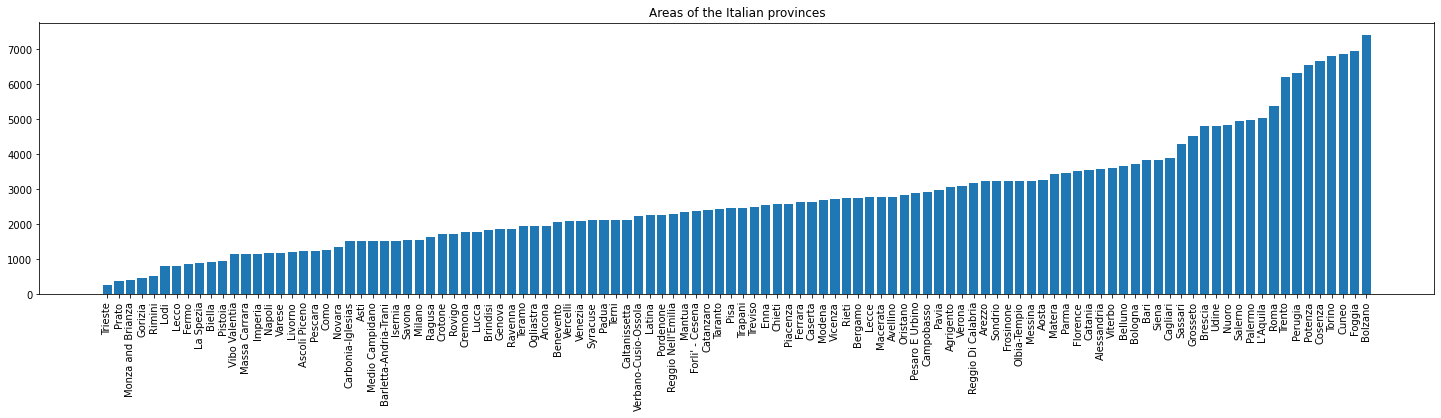

In [ ]:
#to get proper areas it's necessary to adapt the crs (I use)
gdf_pro = provinces.copy(deep = True)
gdf_pro = gdf_pro.to_crs(f"+proj=cea +lat_0={itc_lat} +lon_0={itc_lng} +units=m")

#adding the area in squared km to the gdf next to the name so I can confirm correctness
gdf_pro.insert(4, 'AREA', gdf_pro.area / 10**6)

#sorting regions by area
provinces_by_area = np.array(sorted(gdf_pro[['NAME_2', 'AREA', 'geometry']].values, key=lambda x: x[1]))

#plotting the result
plt.figure(figsize=(25,5))
plt.bar(provinces_by_area[:,0], provinces_by_area[:,1])
plt.xticks(rotation=90, fontsize=10)
plt.title('Areas of the Italian provinces', fontsize=12)

## Municipalities

Municipalities in the gdf: 8100


Text(0.5, 1.0, 'Areas of the Italian municipalities')

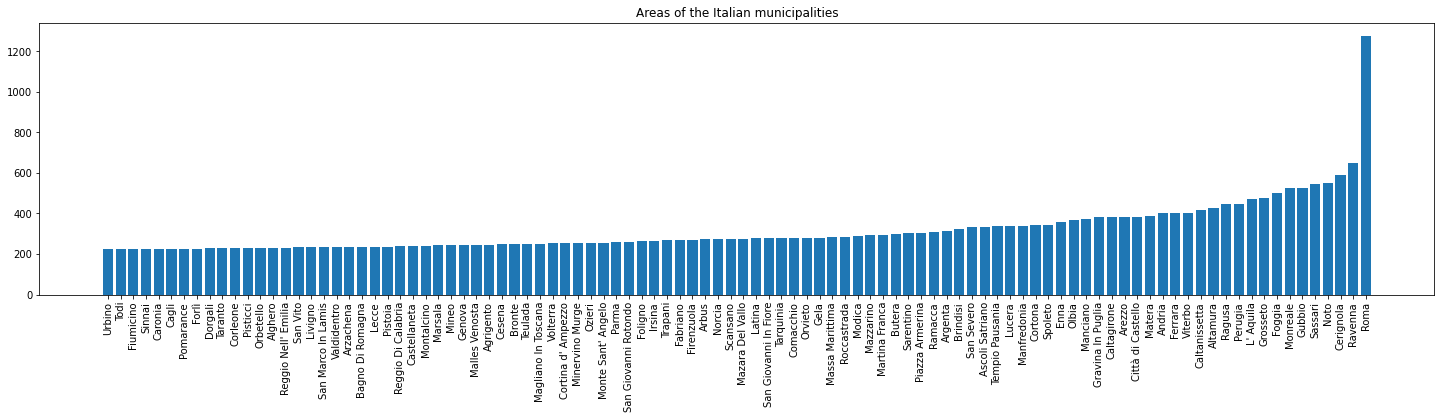

In [ ]:
#to get proper areas it's necessary to adapt the crs (I use)
gdf_mun = municipalities.copy(deep = True)
gdf_mun = gdf_mun.to_crs(f"+proj=cea +lat_0={itc_lat} +lon_0={itc_lng} +units=m")
print(f'Municipalities in the gdf: {len(gdf_mun)}')

#adding the area in squared km to the gdf next to the name so I can confirm correctness
gdf_mun.insert(4, 'AREA', gdf_mun.area / 10**6)

#sorting regions by area
municipalities_by_area = np.array(sorted(gdf_mun[['NAME_3', 'AREA', 'geometry']].values, key=lambda x: x[1]))[-100:]

#plotting the result
plt.figure(figsize=(25,5))
plt.bar(municipalities_by_area[:,0], municipalities_by_area[:,1])
plt.xticks(rotation=90, fontsize=10)
plt.title('Areas of the Italian municipalities', fontsize=12)

## Plotting the shape of Region Capitals (in red) over the regions (in blue)

In [ ]:
capitals = ["L' Aquila", 'Bari', 'Potenza', 'Reggio Di Calabria', 'Napoli', 'Bologna', 
            'Trieste', 'Roma', 'Genova', 'Milano', 'Ancona', 'Campobasso', 'Torino', 
            'Cagliari', 'Palermo', 'Firenze', 'Trento', 'Perugia', 'Aosta', 'Venezia']

In [ ]:
len(capitals)

20

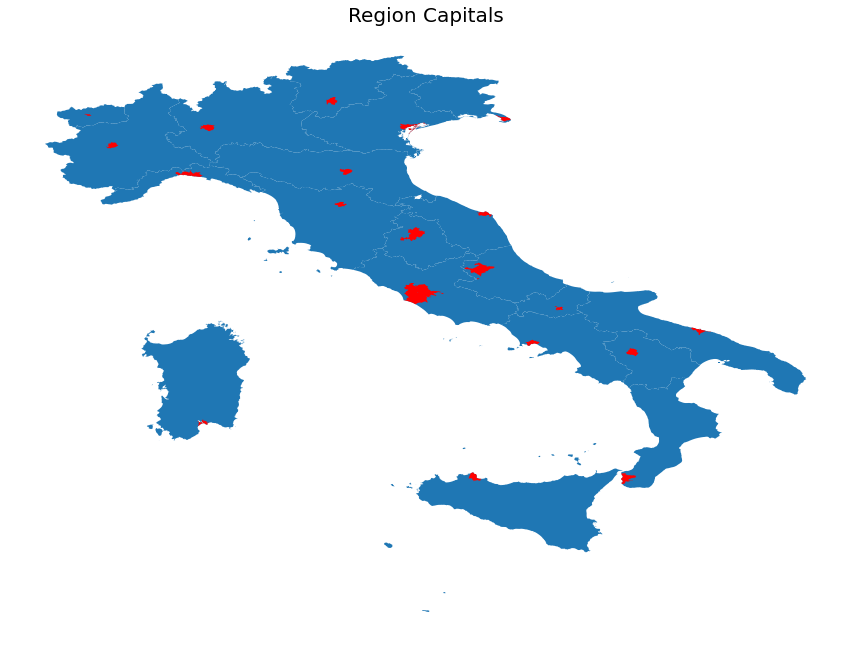

In [ ]:
#plotting the location of the 100 largest cities on the italian map
fig, ax = plt.subplots() #plotting figure and axes

#fixing aspect of the plot
fig.set_figheight(15)
fig.set_figwidth(15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing ticks from map
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plotting the regions
gdf_reg.plot(ax = ax)

for capital in capitals:
    gdf_mun[gdf_mun['NAME_3'] == capital].plot(ax = ax, color = 'red')

plt.title('Region Capitals', fontsize=20)
plt.show()

## Plotting the shape of 100 largest municipalities (in red) over the regions (in blue)

Number of Municipalities: 100


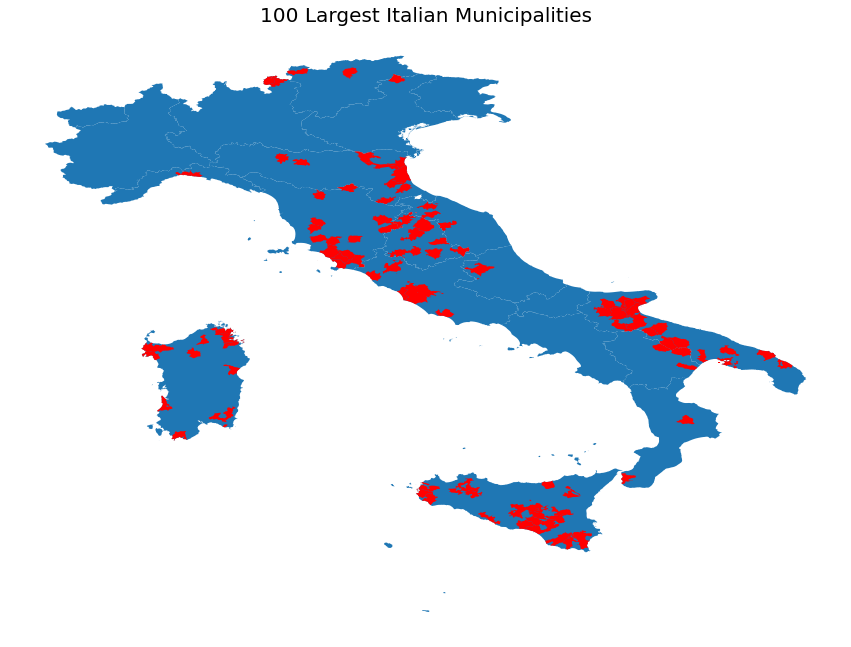

In [ ]:
#excluding areas smaller than the smallest I selected in the previous plot
smallest_area_mun = municipalities_by_area[:1,1][0]

#redefining the gdf of municipalities with area larger than the smallest
gdf_mun_100 = gdf_mun[gdf_mun['AREA'] >= smallest_area_mun]
print(f'Number of Municipalities: {len(gdf_mun_100)}')

#plotting the location of the 100 largest cities on the italian map
fig, ax = plt.subplots() #plotting figure and axes

#fixing aspect of the plot
fig.set_figheight(15)
fig.set_figwidth(15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing ticks from map
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plotting the result on the same axes in order
gdf_reg.plot(ax = ax)
gdf_mun_100.plot(ax = ax, color='red')
plt.title('100 Largest Italian Municipalities', fontsize=20)
plt.show()